In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

import matplotlib
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
%%capture
%run -t monitor_daily_rotation.ipynb
%store -r MONITOR_TARGET
%store -r stock_df_dict

,SYMBOL,DATE,CLOSE,MA,MADIFF,N_chg,N_sht
0,399300,2019-06-06,3564.680,3639.307647,-2.09%,-0.81%,3593.9100
1,000905,2019-06-06,4678.780,4916.325294,-5.08%,-3.37%,4841.7600
2,399006,2019-06-06,1416.060,1479.067647,-4.45%,-1.92%,1443.7500
3,BTC,2019-06-08,8039.000,7935.960000,1.28%,1.38%,7929.2000
4,EOS,2019-06-08,6.644,6.552567,1.38%,2.83%,6.4610
5,ETH,2019-06-08,251.550,244.019000,2.99%,1.26%,248.4200
6,XRP,2019-06-08,0.427,0.398463,6.68%,0.31%,0.4257
7,LTC,2019-06-08,119.060,100.289000,15.77%,2.80%,115.8200


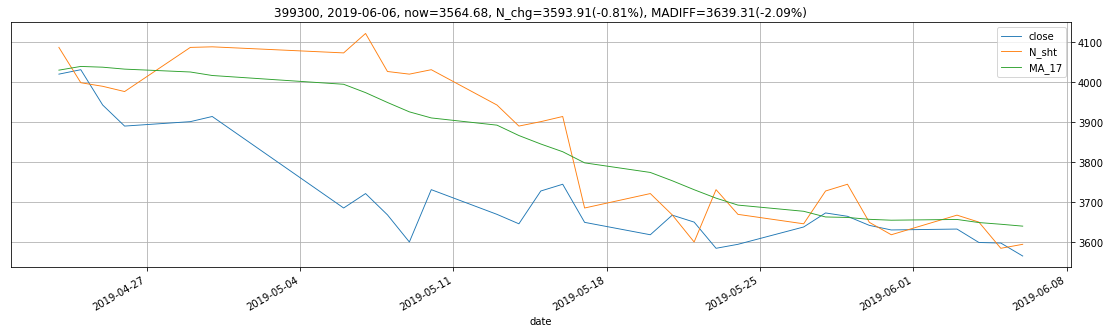

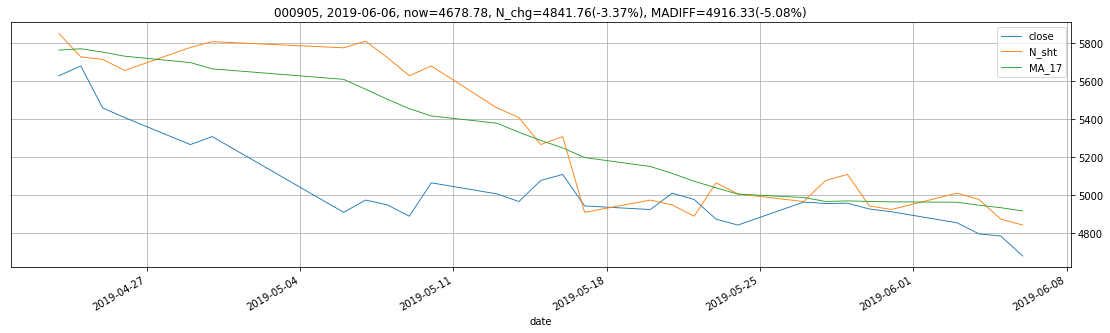

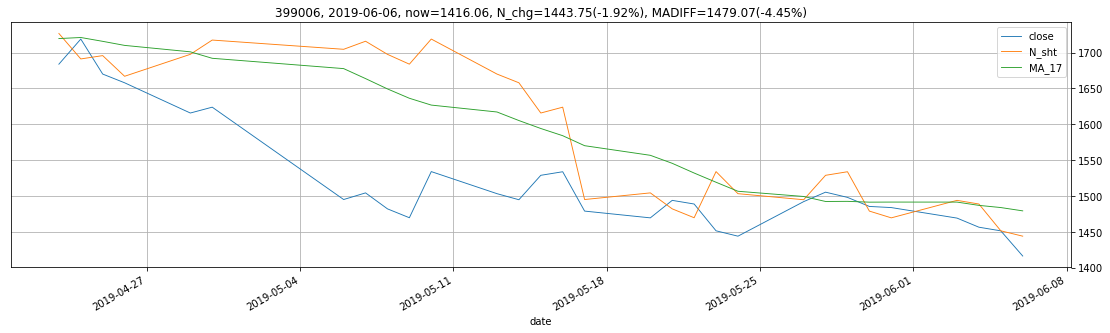

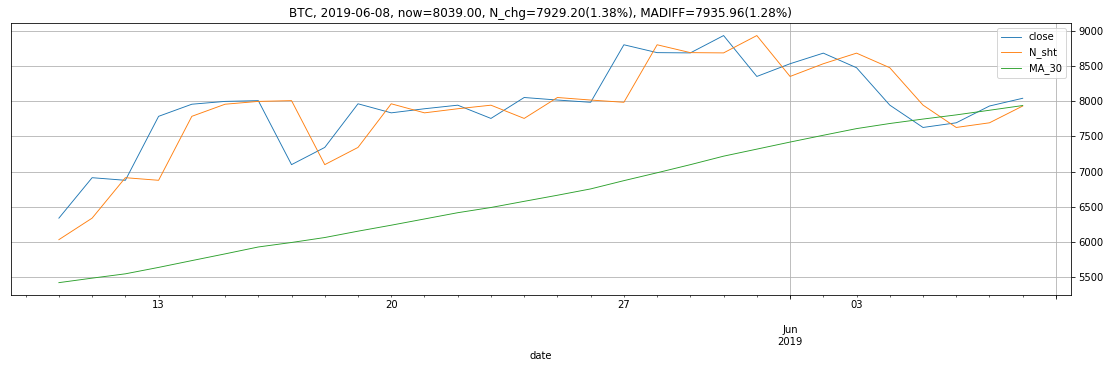

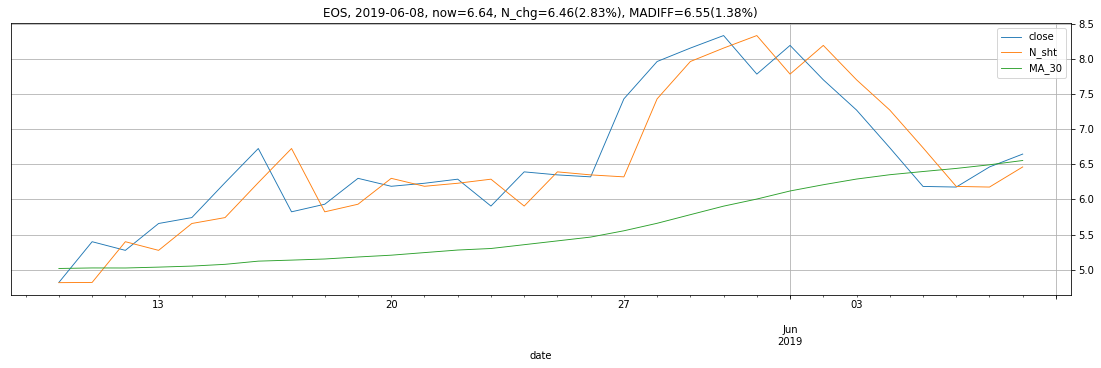

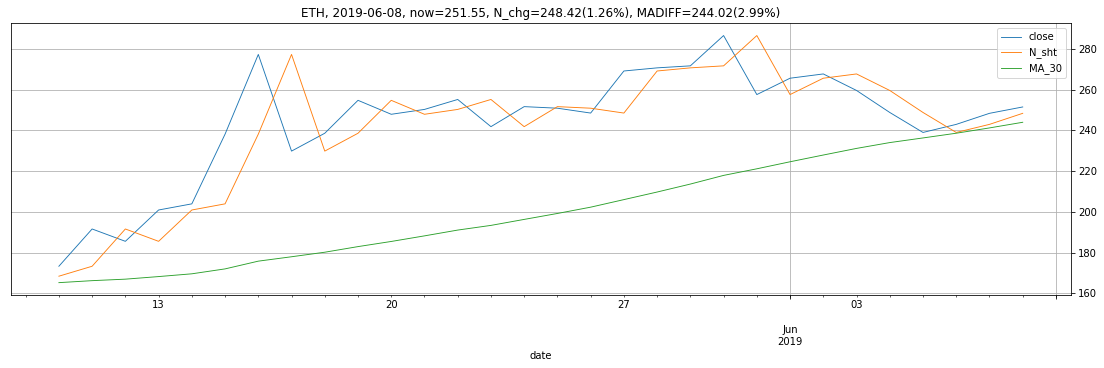

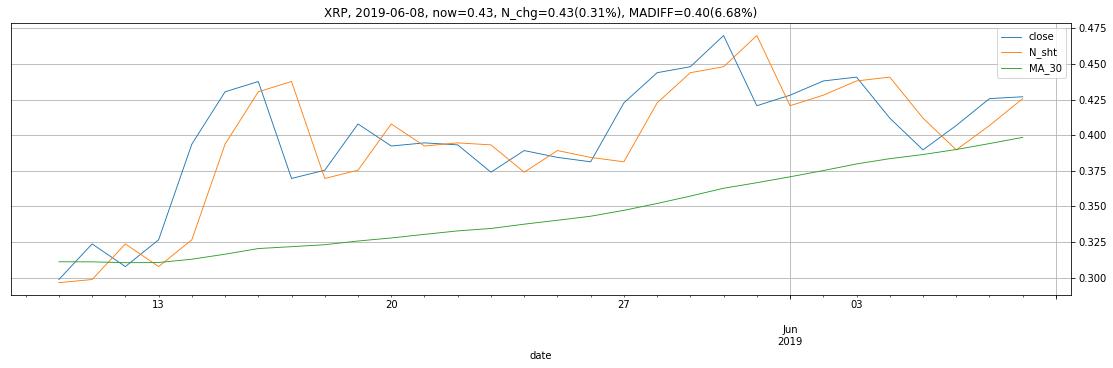

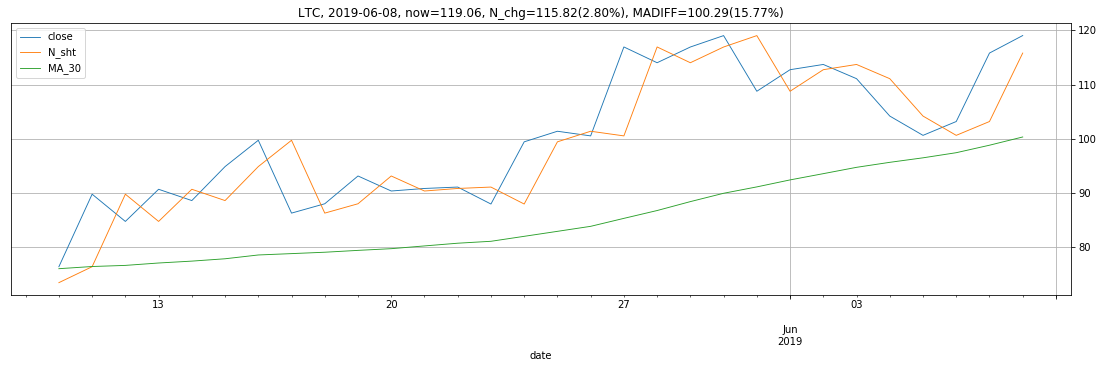

In [3]:
monitor_df = pd.DataFrame(columns=['SYMBOL', 'DATE', 'CLOSE'])

for symbol in MONITOR_TARGET:
    df = stock_df_dict[symbol].iloc[-30:].copy()
    
    df.reset_index(drop=False, inplace=True)
    df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
    df.set_index('date', inplace=True)
    
    today_market = df.iloc[-1]
    now_point = today_market.close
    for col in df.columns:
        if 'ROLLINGMAX' in col:
            buy_point = today_market[col]
            buy_diff = (buy_point - now_point) / now_point * 100
        elif 'ROLLINGMIN' in col:
            sell_point = today_market[col]
            sell_diff = (now_point - sell_point) / now_point * 100
        elif 'MA' in col:
            ma = today_market[col]
            ma_diff = (now_point - ma) / now_point * 100
        elif 'N_chg' in col:
            n_chg = today_market[col] * 100
    
    monitor_df = monitor_df.append({
        'SYMBOL': symbol, 
        'DATE': today_market.name.date(), 
        'CLOSE': now_point, 
        'MA': ma,
        'MADIFF': '%.2f%%' % ma_diff,
        'N_sht': today_market.N_sht, 
        'N_chg': '%.2f%%' % n_chg,
    }, ignore_index=True)
    
    title = '%s, %s, now=%.2f, N_chg=%.2f(%.2f%%), MADIFF=%.2f(%.2f%%)' % \
        (symbol, today_market.name.date(), now_point, today_market.N_sht, n_chg, ma, ma_diff)
    
    df.drop(columns=['N_chg'], inplace=True)
    ax = df.plot(kind='line', title=title, linewidth=0.9, grid=True, figsize=(19, 5))
    ax.yaxis.tick_right()
    
#     display_charts(df, chart_type='stock', kind='line', title=title, figsize=(1000, 600))

monitor_df